In [ ]:
from itertools import chain
from collections import defaultdict

from torch.utils.data import Subset
from torchvision import datasets

In [ ]:
#데이터 균등 샘플링
def subset_sampler(dataset, classes, max_len):
  target_idx = defaultdict(list)
  for idx, label in enumerate(dataset.train_labels):
    target_idx[int(label)].append(idx)

  indices = list(
      chain.from_iterable(
          [target_idx[idx][:max_len] for idx in range(len(classes))]
      ))

  return Subset(dataset, indices)

In [ ]:
#데이터 로드
train_dataset = datasets.FashionMNIST(root='../datasets', download=True, train=True)
test_dataset = datasets.FashionMNIST(root='../datasets', download=True, train=False)

In [ ]:
classes = train_dataset.classes

In [ ]:
class_to_idx = train_dataset.class_to_idx

In [ ]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
#데이터 샘플링
subset_train_dataset = subset_sampler(dataset=train_dataset, classes=train_dataset.classes, max_len=1000)
subset_test_dataset = subset_sampler(dataset=test_dataset, classes=test_dataset.classes, max_len=100)

In [ ]:
print(f'Training Data Size : {len(subset_train_dataset)}')
print(f'Training Data Size : {len(subset_test_dataset)}')

Training Data Size : 10000
Training Data Size : 1000


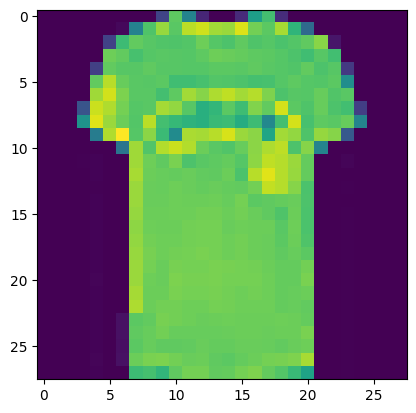

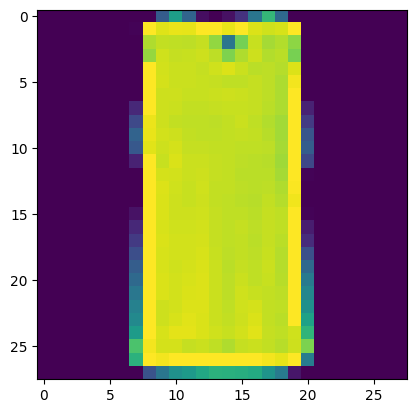

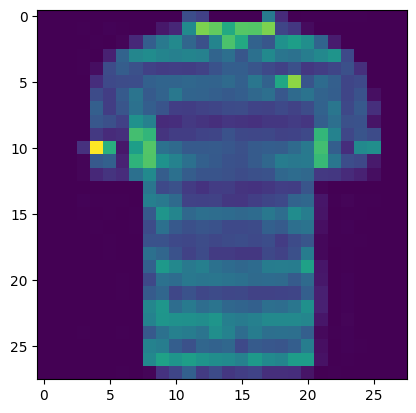

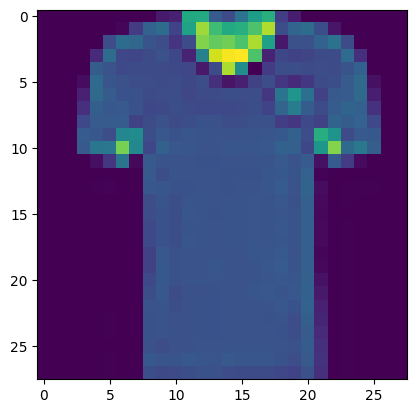

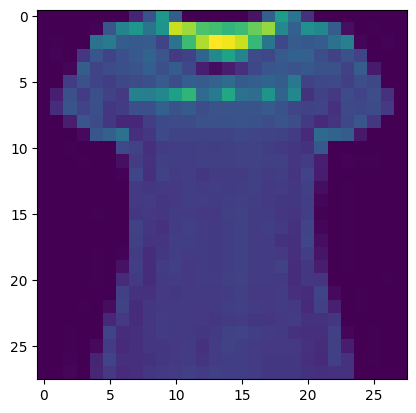

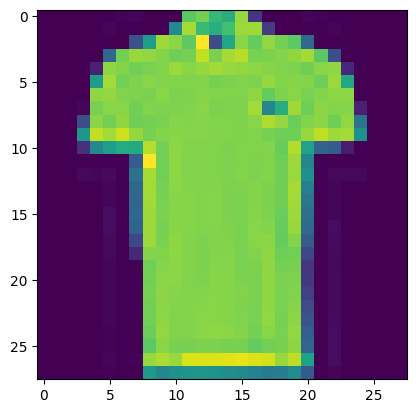

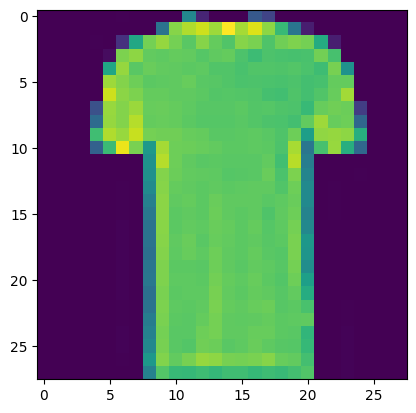

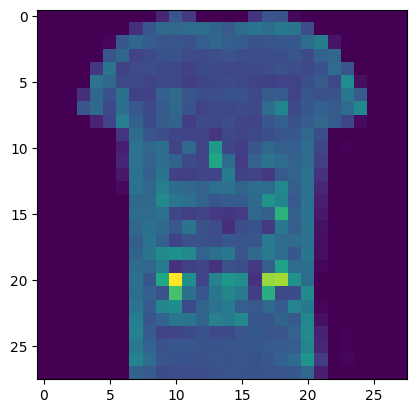

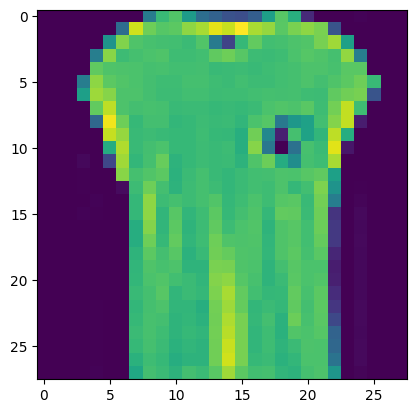

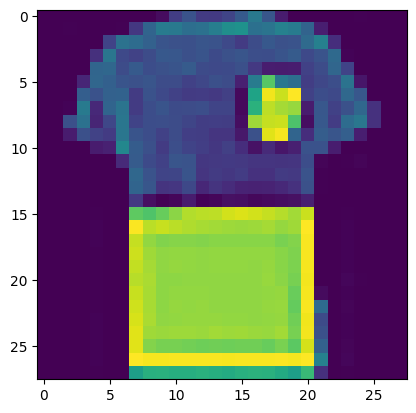

In [ ]:
from PIL import Image
cnt=0
for i in subset_test_dataset:
  if cnt <10:
    plt.imshow(i[0])
    plt.show()
  cnt+=1

In [ ]:
#모델 학습을 위해서는 PIL.Image 형식이 아닌 Tensor 형식으로 변환하는 전처리가 필요하다.
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

#허깅 페이스의 이미지 프로세서 클래스 AutoImageProcessor 사용하여 전처리
#사전 학습된 ViT 모델을 활용하여 전처리를 진행
#해당 클래스는 crop, resize 등을 수행할 수 있다.
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path='google/vit-base-patch16-224-in21k'
)



transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size['height'],
                image_processor.size['width']
            )
        ),
        transforms.Lambda(
            lambda x : torch.cat([x,x,x], 0)  #단일 채널을 복제하여 다중 채널로 변경
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f'size:{image_processor.size}')
print(f'mean:{image_processor.image_mean}')
print(f'std:{image_processor.image_std}')

size:{'height': 224, 'width': 224}
mean:[0.5, 0.5, 0.5]
std:[0.5, 0.5, 0.5]


In [ ]:
#ViT 모델의 입력은 {'pixel_values':pixcel_values, 'labels':labels} 의 딕셔너리 형태로 받는다.
#데이터 로더 적용
from torch.utils.data import DataLoader